In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
n_asset = 4

In [3]:
mu = np.linspace(50, 200, n_asset) / 1e4
sigma = np.linspace(300, 800, n_asset) / 1e4
cov = np.diag(sigma ** 2)

In [4]:
df_0 = pd.read_csv("results/models/dp_tc_0_assets_2", index_col=0, dtype=np.float32)
df_01 = pd.read_csv("results/models/dp_tc_0.001_assets_2", index_col=0, dtype=np.float32)
df_02 = pd.read_csv("results/models/dp_tc_0.002_assets_2", index_col=0, dtype=np.float32)
df_05 = pd.read_csv("results/models/dp_tc_0.0005_assets_2", index_col=0, dtype=np.float32)

In [5]:
state_possible = pd.to_numeric(df_0.index.values)
action_possible = pd.to_numeric(df_0.columns.values)

In [6]:
# List of n_asset values
n_assets_list = [2, 4]

# List of transaction cost values
tc_list = [0, 0.0005, 0.001, 0.002]

df_list = [df_0, df_05, df_01, df_02]

In [7]:

#######################################################################################################################
# Define Necessary Functions
#######################################################################################################################


# Net Sharpe Ratio
def net_sharpe(w1, mu, cov, w0, tc):
    """

    :param w1: next state
    :param mu: mean
    :param cov: covariance diagonal matrix
    :param w0: current state
    :param tc: transaction costs
    :return: net sharpe value
    """
    return (w1.dot(mu) - cost_turnover(w0, w1, tc)) / np.sqrt(w1.dot(cov).dot(w1))


# Objective Function
def obj_func(x, mu, cov):
    """
    Objective Function for the Mean Variance optimization algorithm.
    :param x: tmp weight
    :param mu: mean
    :param cov: covariance diagonal matrix
    :return:
    """
    return -x.dot(mu) / np.sqrt(x.dot(cov).dot(x))
    # return 0.5 * (x.dot(cov).dot(x)) - x.dot(mu)


# Finding Optimal Weight given mean and covariance
def find_optimal_wgt(mu, cov):
    # TODO: Should we change w_max to 1 or to 2/n ? so if n = 8 limit would be 0.25 in one asset?
    n = len(mu)
    w_min = np.zeros(n)
    w_max = np.ones(n) * 2 / n
    x0 = np.ones(n) / n
    bounds = np.vstack([w_min, w_max]).T

    cstr = [{"type": "eq", "fun": lambda x: np.sum(x) - 1, "jac": lambda x: np.ones(n)}]
    opt = minimize(fun=obj_func, x0=x0, args=(mu, cov),
                   bounds=bounds,
                   constraints=cstr,
                   tol=1e-6,
                   options={"maxiter": 10000})

    if not opt.success:
        raise ValueError("optimization failed: {}".format(opt.message))

    return opt.x / opt.x.sum()


def cost_turnover(w0, w1, tc):
    """

    :param w0: current state weights
    :param w1: next state weights
    :param tc: transaction costs
    :return: cost turnover value
    """
    return np.sum(np.abs(w1 - w0) * tc) / 2


def expected_cost_total(w0, w1, opt_w, mu, cov, tc):
    """

    :param w0: current state weights
    :param w1: next state weights
    :param opt_w: optimal mean-variance weights
    :param mu: mean of returns
    :param cov: covariance of returns
    :param tc: transaction costs
    :return: expected cost of optimal - state net sharpe values
    """
    opt_net_sharpe = net_sharpe(w1=opt_w, mu=mu, cov=cov, w0=w0, tc=tc)
    w1_net_sharpe = net_sharpe(w1=w1, mu=mu, cov=cov, w0=w0, tc=tc)
    return opt_net_sharpe - w1_net_sharpe

In [8]:
action_df = pd.DataFrame(index=state_possible)
action_bm_df = pd.DataFrame(index=state_possible)
for tc, bell in zip(tc_list, df_list):
    # visualize q table
    action = np.array([action_possible[i] for i in np.argmax(bell, axis=1)])
    action_df[f"TC: {tc * 1e4:.0f} bps"] = action
    action_bm = []
    for i in state_possible:
        a = state_possible[np.argmax([net_sharpe(np.array([j, 1 - j]), mu, cov, np.array([i, 1 - i]), tc) for j in state_possible])] - i
        action_bm.append(a)
    action_bm = np.array(action_bm)
    action_bm_df[f"TC: {tc * 1e4:.0f} bps BM"] = action_bm

In [9]:
optimal_weight = find_optimal_wgt(mu, cov)
optimal_weight

array([0.63941273, 0.36058727])

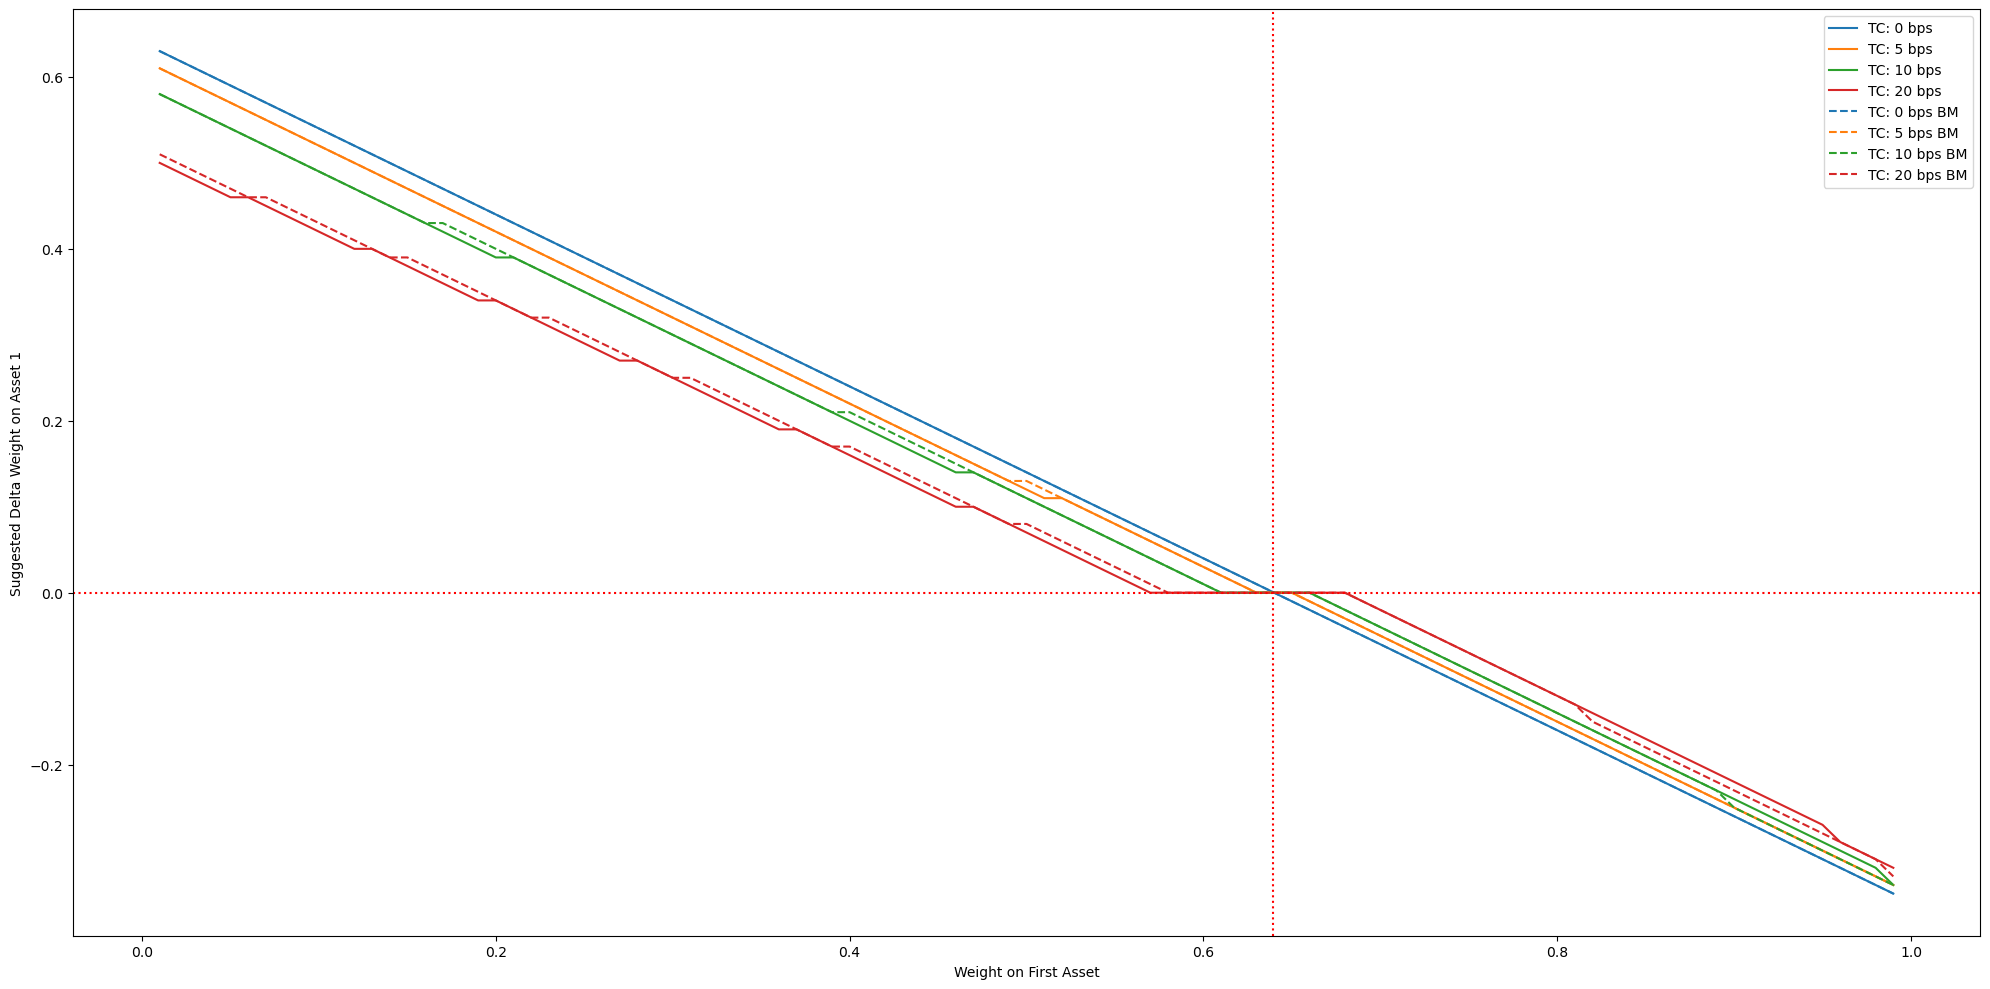

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
action_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
action_bm_df.plot(ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], linestyle="dashed")
ax.set_xlabel("Weight on First Asset")
ax.set_ylabel("Suggested Delta Weight on Asset 1")
ax.axvline(optimal_weight[0], color="red", linestyle="dotted")
ax.axhline(0, color="red", linestyle="dotted")
ax.legend()
plt.tight_layout()
plt.show()
plt.close()
